## Classification with detailed prompts

Importing two DataSets from Kaggle and one downloaded dataset suggested by the professor.

In [28]:
import os

print("Alik dataset folders:", os.listdir("forest_fire_alik"))
print("Kutay dataset folders:", os.listdir("forest_fire_kutay"))

Alik dataset folders: ['Forest Fire Dataset']
Kutay dataset folders: ['train-smoke', 'test_big', 'train_fire', 'test_small']


Loading our third data set and then combining all three datasets into one combined_dataset

In [29]:
import cv2
import random
import shutil
from tqdm import tqdm
import re

TARGET_SIZE = (256, 256)
COMBINED_BASE = '/kaggle/working/combined_dataset'

if os.path.exists(COMBINED_BASE):
    shutil.rmtree(COMBINED_BASE)

dirs = {
    'train_fire': os.path.join(COMBINED_BASE, 'train', 'fire'),
    'train_nofire': os.path.join(COMBINED_BASE, 'train', 'nofire'),
    'test_fire': os.path.join(COMBINED_BASE, 'test', 'fire'),
    'test_nofire': os.path.join(COMBINED_BASE, 'test', 'nofire')
}
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

def get_image_paths(folder):
    extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if f.lower().endswith(extensions)] if os.path.exists(folder) else []

def process_images(source_paths, dest_dir, prefix):
    for idx, img_path in enumerate(tqdm(source_paths)):
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            resized = cv2.resize(img, TARGET_SIZE)
            new_name = f"{prefix}_{idx:05d}{os.path.splitext(img_path)[1]}"
            cv2.imwrite(os.path.join(dest_dir, new_name), resized)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

source_base = '/kaggle/working/forest_fire_alik/Forest Fire Dataset'
train_source_fire = os.path.join(source_base, 'Training', 'fire')
train_source_nofire = os.path.join(source_base, 'Training', 'nofire')
test_source = os.path.join(source_base, 'Testing')

train_fire_imgs = get_image_paths(train_source_fire)
train_nofire_imgs = get_image_paths(train_source_nofire)
process_images(train_fire_imgs, dirs['train_fire'], 'ds1_train_fire')
process_images(train_nofire_imgs, dirs['train_nofire'], 'ds1_train_nofire')

test_images = [os.path.join(test_source, f) for f in os.listdir(test_source)
               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
fire_test_imgs = []
nofire_test_imgs = []
for img_path in test_images:
    fname = os.path.basename(img_path).lower()
    if fname.startswith('fire'):
        fire_test_imgs.append(img_path)
    elif fname.startswith('nofire'):
        nofire_test_imgs.append(img_path)
process_images(fire_test_imgs, dirs['test_fire'], 'ds1_test_fire')
process_images(nofire_test_imgs, dirs['test_nofire'], 'ds1_test_nofire')

dataset2_base = '/kaggle/input/dataset-downloaded/Dataset'
dataset2_paths = {
    'train_fire': os.path.join(dataset2_base, "Training and Validation", "fire"),
    'train_nofire': os.path.join(dataset2_base, "Training and Validation", "nofire"),
    'test_fire': os.path.join(dataset2_base, "Testing", "fire"),
    'test_nofire': os.path.join(dataset2_base, "Testing", "nofire")
}
for category, path in dataset2_paths.items():
    imgs = get_image_paths(path)
    process_images(imgs, dirs[category], 'ds2')

dataset3_base = '/kaggle/working/forest_fire_kutay'
dataset3_sources = {
    'test_big': os.path.join(dataset3_base, "test_big"),
    'test_small': os.path.join(dataset3_base, "test_small"),
    'train_smoke': os.path.join(dataset3_base, "train-smoke"),
    'train_fire': os.path.join(dataset3_base, "train_fire")
}

def extract_number(filename):
    basename = os.path.basename(filename)
    match = re.search(r'(\d+)(?=\.\w+$)', basename)
    return int(match.group(1)) if match else float('inf')

test_big = get_image_paths(dataset3_sources['test_big'])
test_big_filtered = [f for f in test_big if re.search(r'\d+\.\w+$', os.path.basename(f))]
test_big_sorted = sorted(test_big_filtered, key=extract_number)

test_small = get_image_paths(dataset3_sources['test_small'])
test_imgs = test_small + test_big_sorted[:415]
process_images(test_imgs, dirs['test_fire'], 'ds3_test')

train_fire = get_image_paths(dataset3_sources['train_fire'])
random.shuffle(train_fire)
train_smoke = get_image_paths(dataset3_sources['train_smoke'])
random.shuffle(train_smoke)
combined_train = train_fire[:600] + train_smoke[:2000]
process_images(combined_train, dirs['train_fire'], 'ds3_train')

print("\nFinal Dataset Statistics:")
for category, path in dirs.items():
    print(f"{category.replace('_', ' ').title()}: {len(os.listdir(path))} images")


100%|██████████| 2600/2600 [00:20<00:00, 128.26it/s]


Final Dataset Statistics:
Train Fire: 4120 images
Train Nofire: 1520 images
Test Fire: 820 images
Test Nofire: 380 images


## Displaying Loaded Data

Displaying some Images to make sure everything is on order.

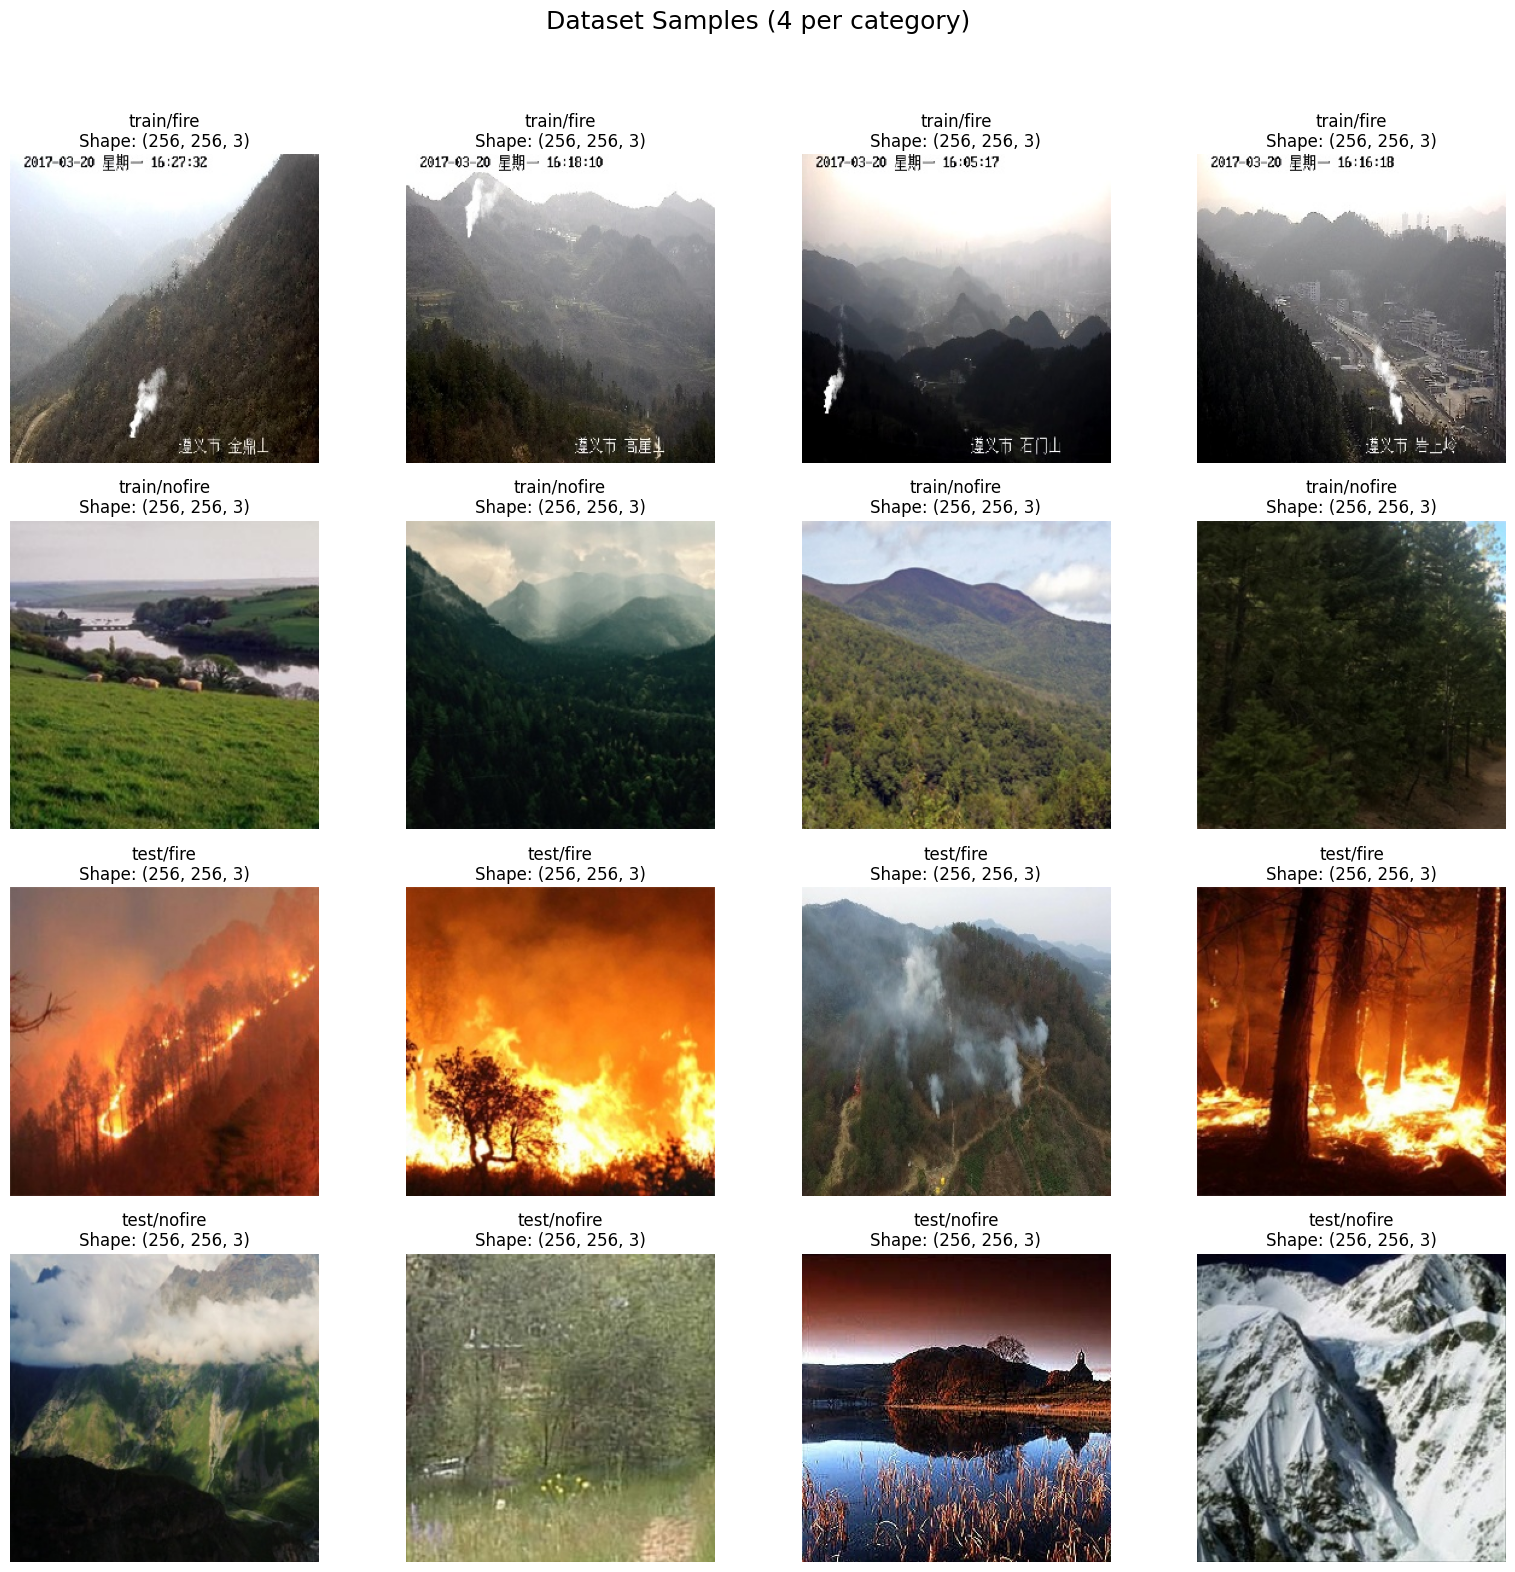

In [30]:
import random
import matplotlib.pyplot as plt

def display_four_per_category(base_path):
    categories = [
        ('train', 'fire'),
        ('train', 'nofire'),
        ('test', 'fire'),
        ('test', 'nofire')
    ]
    
    n_cols = 4
    n_rows = len(categories)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    fig.suptitle('Dataset Samples (4 per category)', fontsize=18)
    
    for row, (split, class_name) in enumerate(categories):
        class_path = os.path.join(base_path, split, class_name)
        if not os.path.exists(class_path):
            for col in range(n_cols):
                axs[row, col].axis('off')
            continue
        
        all_images = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if not all_images:
            for col in range(n_cols):
                axs[row, col].axis('off')
            continue

        if len(all_images) >= n_cols:
            sample_images = random.sample(all_images, n_cols)
        else:
            sample_images = all_images * (n_cols // len(all_images) + 1)
            sample_images = sample_images[:n_cols]

        for col in range(n_cols):
            ax = axs[row, col]
            img_path = os.path.join(class_path, sample_images[col])
            img = cv2.imread(img_path)
            if img is None:
                ax.set_title("Error loading image")
                ax.axis('off')
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{split}/{class_name}\nShape: {img.shape}")
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

dataset_path = '/kaggle/working/combined_dataset'
display_four_per_category(dataset_path)

## Training Data Augmentation

### Random 90° Rotations
- Applies 0/90/180/270° rotations randomly

### Random Flips
- Vertical and horizontal flipping

### Brightness/Contrast Normalization
- Adjusts lighting variations

### Pixel Value Scaling
- [0–255] → [0.0–1.0]

### Color Conversion
- BGR → RGB

It is to note that we applied augmentation to see if the model would be able to classify better using augmented images or not. To that end we augmented aur train data while aur test data remaied unchanged and we applied zero-shot learning to both. In essence Training data's accuracy tells us how accurately the Model Classifies Augmented Images and Test data's accuracy tells us how well the data performs on unaugmented data. We made training testing splits but as they come from the same distribution and we did not use data for training, so all the data can in this scenario be considered test data.

In [31]:
import numpy as np
import pandas as pd

train_fire_dir = '/kaggle/working/combined_dataset/train/fire'
train_nofire_dir = '/kaggle/working/combined_dataset/train/nofire'
TARGET_SIZE = (256, 256)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def apply_random_augmentation(image):

    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 0)
    k = np.random.choice([0, 1, 2, 3])  
    image = np.rot90(image, k)
    return image

def load_and_normalize_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not read properly: {img_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, TARGET_SIZE)
    
    channels = cv2.split(img_resized)
    equalized_channels = [clahe.apply(ch) for ch in channels]
    img_equalized = cv2.merge(equalized_channels)
    
    img_augmented = apply_random_augmentation(img_equalized)
    
    img_normalized = img_augmented.astype(np.float32) / 255.0

    return img_normalized

def process_directory(directory, label):
    allowed_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    img_files = [os.path.join(directory, f) for f in os.listdir(directory) 
                 if f.lower().endswith(allowed_extensions)]
    
    data = []
    for img_path in tqdm(img_files, desc=f"Processing {label} images"):
        try:
            img_proc = load_and_normalize_image(img_path)
            img_flat = img_proc.flatten()
            data.append({
                'image_path': img_path,
                'label': label,
                'image_data': img_flat
            })
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    return data

data_fire = process_directory(train_fire_dir, label='fire')
data_nofire = process_directory(train_nofire_dir, label='nofire')

combined_data = data_fire + data_nofire
df = pd.DataFrame(combined_data)

print("DataFrame shape:", df.shape)
print(df.head())


Processing nofire images: 100%|██████████| 1520/1520 [00:05<00:00, 257.48it/s]

DataFrame shape: (5640, 3)
                                          image_path label  \
0  /kaggle/working/combined_dataset/train/fire/ds...  fire   
1  /kaggle/working/combined_dataset/train/fire/ds...  fire   
2  /kaggle/working/combined_dataset/train/fire/ds...  fire   
3  /kaggle/working/combined_dataset/train/fire/ds...  fire   
4  /kaggle/working/combined_dataset/train/fire/ds...  fire   

                                          image_data  
0  [0.4, 0.38039216, 0.43137255, 0.32156864, 0.30...  
1  [0.03529412, 0.03529412, 0.03529412, 0.0352941...  
2  [0.007843138, 0.007843138, 0.05882353, 0.03921...  
3  [0.3019608, 0.23921569, 0.22352941, 0.3019608,...  
4  [0.06666667, 0.011764706, 0.011764706, 0.09411...  


## Displaing Augmented Images


Preview: Fire samples


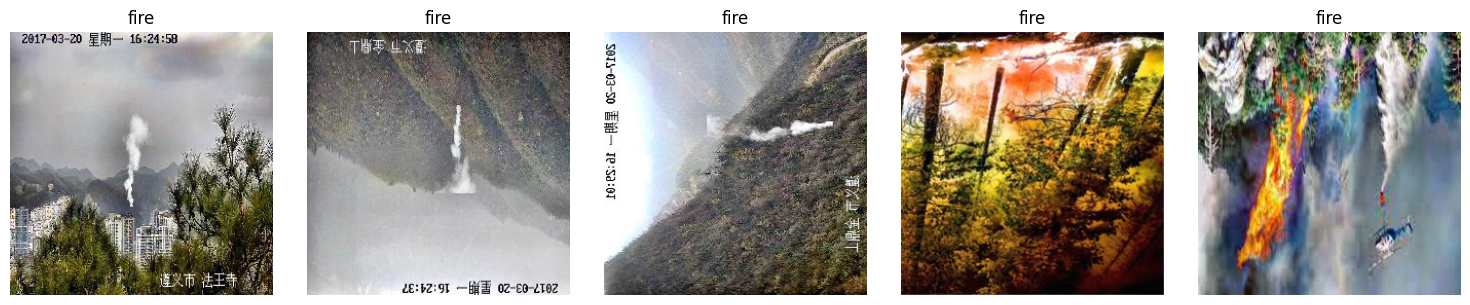


Preview: No-Fire samples


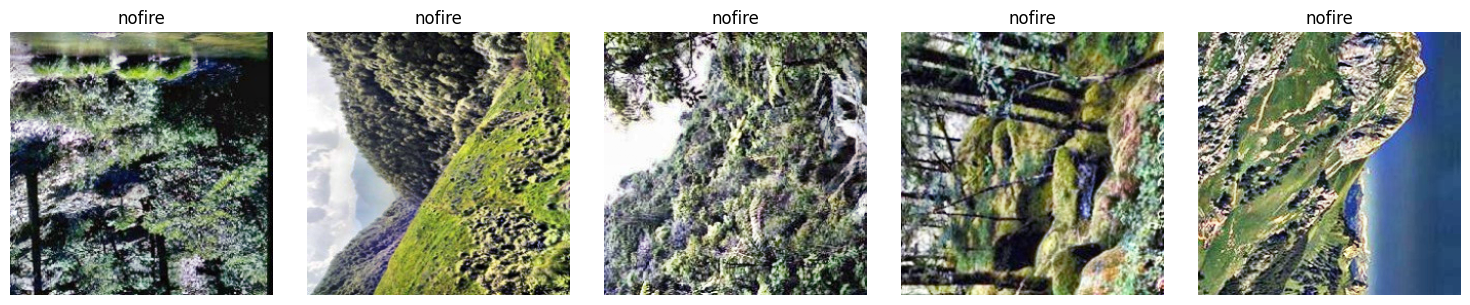

In [32]:
def reshape_image(flattened):
    return flattened.reshape((256, 256, 3))

def show_samples(df, label=None, n=5):
    subset = df[df['label'] == label] if label else df
    sample_rows = subset.sample(n)
    
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img_array = reshape_image(row['image_data'])
        plt.subplot(1, n, i+1)
        plt.imshow(img_array)
        plt.title(row['label'])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nPreview: Fire samples")
show_samples(df, label='fire', n=5)

print("\nPreview: No-Fire samples")
show_samples(df, label='nofire', n=5)

In [33]:
fire_df = df[df['label'] == 'fire']
fire_train = fire_df['image_data'].values

nofire_df = df[df['label'] == 'nofire']
nofire_train = nofire_df['image_data'].values

print("TRAIN FIRE")
print(fire_train[:5])
print("TRAIN NO FIRE")
print(nofire_train[:5])

TRAIN FIRE
[array([0.4       , 0.38039216, 0.43137255, ..., 0.29803923, 0.35686275,
        0.45882353], dtype=float32)
 array([0.03529412, 0.03529412, 0.03529412, ..., 0.61960787, 0.35686275,
        0.01960784], dtype=float32)
 array([0.00784314, 0.00784314, 0.05882353, ..., 0.7921569 , 0.76862746,
        0.7490196 ], dtype=float32)
 array([0.3019608 , 0.23921569, 0.22352941, ..., 0.43529412, 0.2627451 ,
        0.23921569], dtype=float32)
 array([0.06666667, 0.01176471, 0.01176471, ..., 0.89411765, 0.92156863,
        0.96862745], dtype=float32)                                     ]
TRAIN NO FIRE
[array([0.12156863, 0.1254902 , 0.1254902 , ..., 0.9882353 , 0.9882353 ,
        0.9882353 ], dtype=float32)
 array([0.02352941, 0.03137255, 0.07450981, ..., 0.47843137, 0.5803922 ,
        0.8117647 ], dtype=float32)
 array([0.9882353 , 1.        , 0.99215686, ..., 0.47843137, 0.44705883,
        0.41960785], dtype=float32)
 array([0.02352941, 0.03529412, 0.01176471, ..., 0.04313726, 0.09

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import CLIPProcessor, CLIPModel
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from PIL import Image

## Loading CLIP Model

In [35]:
#load the clip model and processor
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

# Baseline Model on Train Data (Augmented)

## Taking 100 Fire Images and 50 Non-Fire Images

This section describes the initial evaluation of our baseline model using a balanced test set:

- **Fire Images**: 100 samples
- **Non-Fire Images**: 50 samples

We will be using a little detailed prompts as mentioned at the very start of the next code block.

In [36]:
text_prompts = [
    "a clear photo showing visible flames or smoke in a forest area", 
    "a normal landscape photo with no signs of fire, smoke, or burning"  
]

def classify_image_from_array(flat_array):
    image_array = np.reshape(flat_array, (256, 256, 3))
    if image_array.max() <= 1.0:
        image_array = (image_array * 255).astype(np.uint8)
    else:
        image_array = image_array.astype(np.uint8)

    image = Image.fromarray(image_array)

    inputs = processor(
        text=text_prompts,
        images=image,
        return_tensors="pt",
        padding="max_length",
        truncation=True
    ).to(device)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    predicted_index = probs.argmax().item()
    predicted_label = "FIRE" if predicted_index == 0 else "NON-FIRE"
    confidence = probs[0][predicted_index].item()
    
    return predicted_label, confidence

fire_df = df[df['label'] == 'fire'].copy()
fire_df = fire_df[:100]
fire_df['true_label'] = 'FIRE'

nofire_df = df[df['label'] == 'nofire'].copy()
nofire_df = nofire_df[:50]
nofire_df['true_label'] = 'NON-FIRE'

combined_df = pd.concat([fire_df, nofire_df]).sample(frac=1).reset_index(drop=True)

total_correct = 0

for i, row in combined_df.iterrows():
    img_flat = row['image_data']
    true_label = row['true_label']

    predicted_label, confidence = classify_image_from_array(img_flat)
    is_correct = predicted_label == true_label
    total_correct += int(is_correct)

    print(f"[{i+1}] True: {true_label}, Predicted: {predicted_label} ({confidence:.2f}) ")

overall_accuracy = total_correct / len(combined_df) * 100

print("ACCURACIES:")
print(f"Overall Accuracy: {total_correct}/{len(combined_df)} = {overall_accuracy:.2f}%")

[1] True: FIRE, Predicted: FIRE (0.95) 
[2] True: FIRE, Predicted: NON-FIRE (0.56) 
[3] True: NON-FIRE, Predicted: NON-FIRE (0.98) 
[4] True: FIRE, Predicted: FIRE (0.99) 
[5] True: FIRE, Predicted: FIRE (0.97) 
[6] True: FIRE, Predicted: FIRE (0.99) 
[7] True: FIRE, Predicted: FIRE (0.65) 
[8] True: FIRE, Predicted: FIRE (0.78) 
[9] True: FIRE, Predicted: FIRE (1.00) 
[10] True: FIRE, Predicted: FIRE (0.98) 
[11] True: FIRE, Predicted: FIRE (0.98) 
[12] True: FIRE, Predicted: FIRE (0.77) 
[13] True: NON-FIRE, Predicted: NON-FIRE (0.75) 
[14] True: FIRE, Predicted: FIRE (0.55) 
[15] True: FIRE, Predicted: FIRE (0.94) 
[16] True: FIRE, Predicted: FIRE (0.93) 
[17] True: FIRE, Predicted: FIRE (0.94) 
[18] True: NON-FIRE, Predicted: NON-FIRE (0.93) 
[19] True: FIRE, Predicted: FIRE (1.00) 
[20] True: FIRE, Predicted: FIRE (1.00) 
[21] True: FIRE, Predicted: FIRE (0.89) 
[22] True: FIRE, Predicted: FIRE (0.98) 
[23] True: FIRE, Predicted: FIRE (0.52) 
[24] True: NON-FIRE, Predicted: NON-FI

Decent Accuracy on Augmented data.

# Baseline Model on Test Data

## Taking 100 Fire Images and 50 Non-Fire Images

This section describes the initial evaluation of our baseline model using a balanced test set:

- **Fire Images**: 100 samples
- **Non-Fire Images**: 50 samples

In [37]:
from PIL import Image
import numpy as np
import pandas as pd

train_fire_dir = '/kaggle/working/combined_dataset/train/fire'
train_nofire_dir = '/kaggle/working/combined_dataset/train/nofire'

def load_images_from_folder(folder, label, max_images):
    images = []
    labels = []
    count = 0
    for filename in os.listdir(folder):
        if count >= max_images:
            break
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB').resize((256, 256))
            img_array = np.array(img)
            flat_array = img_array.flatten()
            images.append(flat_array)
            labels.append(label)
            count += 1
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

fire_images, fire_labels = load_images_from_folder(train_fire_dir, 'FIRE', 100)
nofire_images, nofire_labels = load_images_from_folder(train_nofire_dir, 'NON-FIRE', 50)

combined_df = pd.DataFrame({
    'image_data': fire_images + nofire_images,
    'true_label': fire_labels + nofire_labels
}).sample(frac=1).reset_index(drop=True)  

total_correct = 0

for i, row in combined_df.iterrows():
    img_flat = row['image_data']
    true_label = row['true_label']

    predicted_label, confidence = classify_image_from_array(img_flat)
    is_correct = predicted_label == true_label
    total_correct += int(is_correct)

    print(f"[{i+1}] True: {true_label}, Predicted: {predicted_label} ({confidence:.2f}) ")

overall_accuracy = total_correct / len(combined_df) * 100

print("\nACCURACY RESULTS:")
print(f"Overall Accuracy: {total_correct}/{len(combined_df)} = {overall_accuracy:.2f}%")

[1] True: FIRE, Predicted: FIRE (0.91) 
[2] True: FIRE, Predicted: NON-FIRE (0.82) 
[3] True: FIRE, Predicted: FIRE (0.94) 
[4] True: NON-FIRE, Predicted: NON-FIRE (0.97) 
[5] True: FIRE, Predicted: FIRE (0.99) 
[6] True: FIRE, Predicted: FIRE (1.00) 
[7] True: NON-FIRE, Predicted: FIRE (0.77) 
[8] True: NON-FIRE, Predicted: NON-FIRE (0.80) 
[9] True: FIRE, Predicted: NON-FIRE (0.61) 
[10] True: FIRE, Predicted: FIRE (0.99) 
[11] True: NON-FIRE, Predicted: NON-FIRE (0.52) 
[12] True: FIRE, Predicted: FIRE (0.87) 
[13] True: NON-FIRE, Predicted: NON-FIRE (0.96) 
[14] True: FIRE, Predicted: FIRE (0.97) 
[15] True: FIRE, Predicted: FIRE (0.98) 
[16] True: FIRE, Predicted: FIRE (0.74) 
[17] True: FIRE, Predicted: FIRE (0.66) 
[18] True: FIRE, Predicted: FIRE (0.78) 
[19] True: NON-FIRE, Predicted: NON-FIRE (0.86) 
[20] True: FIRE, Predicted: FIRE (0.94) 
[21] True: FIRE, Predicted: FIRE (0.99) 
[22] True: NON-FIRE, Predicted: FIRE (0.91) 
[23] True: FIRE, Predicted: FIRE (0.95) 
[24] True:

The model performs better on data without Augmentation as compared to data with augmentation.